# Bandpass temperature difference with t-test

## Import package

In [5]:
import numpy as np
import joblib as jl
import netCDF4 as nc

from scipy.stats import t
from matplotlib.colors import TwoSlopeNorm
from matplotlib import pyplot as plt

## Load data

In [6]:
CNTL = jl.load('CNTL_t_sel.joblib')
NCRF = jl.load('NCRF_t_sel.joblib')

# Load temperature PC data
temp: dict[str, dict[str, np.ndarray]] = dict(
    pc1 = dict(
        CNTL = CNTL["pc1"]["t"][:, None, :],
        NCRF = NCRF["pc1"]["t"][:, None, :]
    ),
    pc2 = dict(
        CNTL = CNTL["pc2"]["t"][:, None, :],
        NCRF = NCRF["pc2"]["t"][:, None, :]
    )
)

# load EOf structure
with nc.Dataset("/work/b11209013/2024_Research/MPAS/PC/EOF.nc", 'r') as f:
    lev = f.variables["lev"][:]
    eof = dict(
        pc1 = f.variables["EOF"][0],
        pc2 = f.variables["EOF"][1]
    )

### Construct 3D data

In [7]:
# permute and reshape
temp_rs: dict[str, dict[str, np.ndarray]] = dict(
    pc1 = dict(
        CNTL = temp["pc1"]["CNTL"].transpose(1, 0, 2).reshape(1, -1),
        NCRF = temp["pc1"]["NCRF"].transpose(1, 0, 2).reshape(1, -1)
    ),
    pc2 = dict(
        CNTL = temp["pc2"]["CNTL"].transpose(1, 0, 2).reshape(1, -1),
        NCRF = temp["pc2"]["NCRF"].transpose(1, 0, 2).reshape(1, -1)
    )
)

# form vertyical profile
temp_vert: dict[str, dict[str, np.ndarray]] = dict(
    pc1 = dict(
        CNTL = np.matmul(eof["pc1"][:, None], temp_rs["pc1"]["CNTL"]),
        NCRF = np.matmul(eof["pc1"][:, None], temp_rs["pc1"]["NCRF"])
    ),
    pc2 = dict(
        CNTL = np.matmul(eof["pc2"][:, None], temp_rs["pc2"]["CNTL"]),
        NCRF = np.matmul(eof["pc2"][:, None], temp_rs["pc2"]["NCRF"])
    )
)

# reshape to 3D
temp_3d: dict[str, dict[str, np.ndarray]] = dict(
    pc1 = dict(
        CNTL = temp_vert["pc1"]["CNTL"].reshape(lev.size, temp["pc1"]["CNTL"].shape[0], temp["pc1"]["CNTL"].shape[2]).transpose(1, 0, 2),
        NCRF = temp_vert["pc1"]["NCRF"].reshape(lev.size, temp["pc1"]["NCRF"].shape[0], temp["pc1"]["NCRF"].shape[2]).transpose(1, 0, 2)
    ),
    pc2 = dict(
        CNTL = temp_vert["pc2"]["CNTL"].reshape(lev.size, temp["pc1"]["CNTL"].shape[0], temp["pc1"]["CNTL"].shape[2]).transpose(1, 0, 2),
        NCRF = temp_vert["pc2"]["NCRF"].reshape(lev.size, temp["pc1"]["NCRF"].shape[0], temp["pc1"]["NCRF"].shape[2]).transpose(1, 0, 2)
    )
)

temp_sel: dict[str, np.ndarray] = dict(
    CNTL = temp_3d["pc1"]["CNTL"] + temp_3d["pc2"]["CNTL"],
    NCRF = temp_3d["pc1"]["NCRF"] + temp_3d["pc2"]["NCRF"]
)

## T-test

In [8]:
mean: dict[str, np.ndarray] = dict(
    CNTL = temp_sel["CNTL"].mean(axis=0),
    NCRF = temp_sel["NCRF"].mean(axis=0)
)

std_err: dict[str, np.ndarray] = dict(
    CNTL = temp_sel["CNTL"].var(axis=0)/temp_sel["CNTL"].shape[0],
    NCRF = temp_sel["NCRF"].var(axis=0)/temp_sel["NCRF"].shape[0]
)

t_score = (mean["CNTL"] - mean["NCRF"]) / np.sqrt(std_err["NCRF"] + std_err["CNTL"])

dof = (std_err["NCRF"] + std_err["CNTL"])**2 / (std_err["NCRF"]**2/(temp_sel["NCRF"].shape[0]-1) + std_err["CNTL"]**2/(temp_sel["CNTL"].shape[0]-1))

critical_value = t.ppf(0.975, dof)

significant_diff = np.where(np.abs(t_score) > critical_value, 1, np.nan)

## Plotting

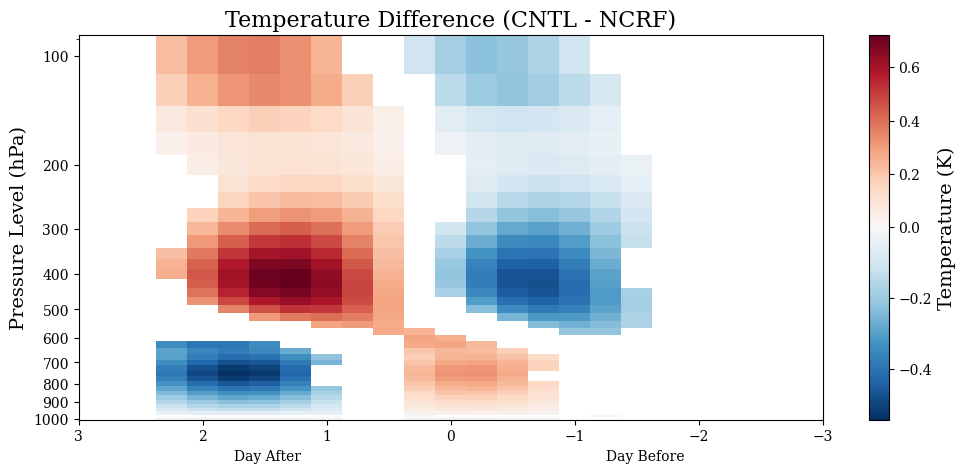

In [12]:
plt.rcParams.update({
    'font.size': 10,
    'figure.titlesize': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'font.family': 'serif',
})

plt.figure(figsize=(12, 5))
plt.pcolormesh(np.linspace(-4, 4, 33), lev, ((mean["CNTL"] - mean["NCRF"])*significant_diff), cmap="RdBu_r", norm=TwoSlopeNorm(vcenter=0))
plt.yscale("log")
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10, dtype=int))
plt.xlim(-3, 3)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.ylabel("Pressure Level (hPa)")
plt.text(1.75, 1300, "Day After")
plt.text(-1.25, 1300, "Day Before")
plt.title("Temperature Difference (CNTL - NCRF)")
cb = plt.colorbar(label="Temperature (K)")
plt.savefig("bandpass_diff.png", dpi=300)